# E3-3. Unet_Building_256_256_crop_with_hdf5
---

## Environment Setting
---

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import rasterio
from rasterio.plot import show

import math
from tqdm import tqdm

In [2]:
import tensorflow as tf
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')

            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e, "\n\n")

init_gpu()

1 Physical GPUs, 1 Logical GPUs




In [3]:
FILE_PATH = './data/E3.h5'
BASE_TARIN_DIR = "/B/train"
TRAIN_IMG_PATH = f'{Path(BASE_TARIN_DIR)}/img'
TRAIN_LABEL_PATH = f'{Path(BASE_TARIN_DIR)}/label'
TRAIN_SPLIT_DIR = f'{Path(BASE_TARIN_DIR)}/split'  
TRAIN_SPLIT_IMG_PATH = f'{Path(BASE_TARIN_DIR)}/split/img'           
TRAIN_SPLIT_LABEL_PATH = f'{Path(BASE_TARIN_DIR)}/split/label'                                                                                                                         

BASE_VAL_DIR = "/B/val"
VAL_IMG_PATH = f'{Path(BASE_VAL_DIR)}/img'
VAL_LABEL_PATH = f'{Path(BASE_VAL_DIR)}/label'
VAL_SPLIT_DIR = f'{Path(BASE_VAL_DIR)}/split'  
VAL_SPLIT_IMG_PATH = f'{Path(BASE_VAL_DIR)}/split/img'           
VAL_SPLIT_LABEL_PATH = f'{Path(BASE_VAL_DIR)}/split/label'  

IMAGE_SIZE = 1024
IMG_CHANNELS = 3


COLOR_MAP = [
    (165, 42, 42),
    (0, 192, 0),
    (255,255,255)
]

## Split and Save image
---

### 함수정의

In [4]:
def get_slice_pos(split_cnt, STRIDE_SIZE, INPUT_SIZE):
    pts = []
    for slice_pos in range(split_cnt):
        pos_i = int(math.floor(slice_pos / 5.0))
        pos_j = int(slice_pos % 5)
        x = STRIDE_SIZE * pos_i
        y = STRIDE_SIZE * pos_j
        pts.append((x, x+INPUT_SIZE, y, y+INPUT_SIZE))
    return pts

In [5]:
def split_png(img, pts):
    if len(img.shape) == 3:
        sub_imgs = [img[x0:x1, y0:y1, :] for x0, x1, y0, y1 in pts]
    elif len(img.shape) == 2:
        sub_imgs = [img[x0:x1, y0:y1] for x0, x1, y0, y1 in pts]
    return sub_imgs

In [6]:
def save_png_imgs_labels(dataset, i, imgs, labels):
    for img, label in zip(imgs, labels):
        dataset['img'][i, ...] = img
        dataset['label'][i, ...] = label
        i += 1
    return i

### Split

In [7]:
STRIDE_SIZE = 192
INPUT_SIZE = 256
SPLIT_CNT = 25
pts = get_slice_pos(SPLIT_CNT, STRIDE_SIZE, INPUT_SIZE)


In [8]:

# with h5py.File(FILE_PATH, "a") as f:
#     train_size = f[TRAIN_IMG_PATH].shape[0] * 25
#     del f[TRAIN_SPLIT_DIR]
#     f[BASE_TARIN_DIR].create_group('split')
#     f[BASE_TARIN_DIR]['split'].create_dataset('img', (train_size, 256, 256, 3), np.uint8)
#     f[BASE_TARIN_DIR]['split'].create_dataset('label', (train_size, 256, 256), np.float)

#     val_size = f[VAL_IMG_PATH].shape[0] * 25
#     del f[VAL_SPLIT_DIR]
#     f[BASE_VAL_DIR].create_group('split')
#     f[BASE_VAL_DIR]['split'].create_dataset('img', (val_size, 256, 256, 3), np.uint8)
#     f[BASE_VAL_DIR]['split'].create_dataset('label', (val_size, 256, 256), np.float)

#     sub_idx = 0
#     for i in tqdm(range(f[TRAIN_IMG_PATH].shape[0])):
#         sub_imgs = split_png(f[TRAIN_IMG_PATH][i], pts)

#         mask = (f[TRAIN_LABEL_PATH][i] == COLOR_MAP[0])
#         mask = (mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype('float')
#         sub_labels = split_png(mask, pts)
        
#         sub_idx = save_png_imgs_labels(f[TRAIN_SPLIT_DIR], sub_idx, sub_imgs, sub_labels)

#     sub_idx = 0
#     for i in tqdm(range(f[VAL_IMG_PATH].shape[0])):
#         sub_imgs = split_png(f[VAL_IMG_PATH][i], pts)

#         mask = (f[VAL_IMG_PATH][i] == COLOR_MAP[0])
#         mask = (mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype('float')
#         sub_labels = split_png(mask, pts)

#         sub_idx = save_png_imgs_labels(f[VAL_SPLIT_DIR], sub_idx, sub_imgs, sub_labels)

### Sample

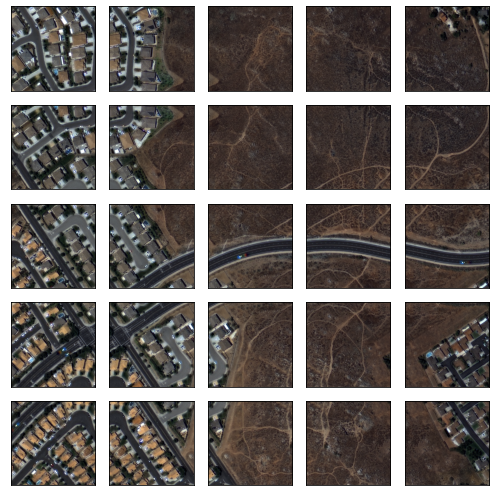

In [9]:
with h5py.File(FILE_PATH, "a") as f:
    imgs = f[TRAIN_SPLIT_IMG_PATH][:25]
    plt.figure(figsize=(7, 7))
    for i, sub_img in enumerate(imgs):
        plt.subplot(5, 5, i+1)
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.imshow(sub_img)
            
    plt.tight_layout()
    plt.show()

## Dataloader and utility functions
---

In [10]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    fig, axs = plt.subplots(1, n, figsize=(10, 5))
    
    for i, (name, image) in enumerate(images.items()):
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(' '.join(name.split('_')).title())
        axs[i].imshow(image)
        
    plt.tight_layout()
    plt.show()

In [11]:
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [12]:
import segmentation_models as sm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BACKBONE = 'efficientnetb3'
preprocessing_fn=sm.get_preprocessing(BACKBONE)
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True,
                                   preprocessing_function=preprocessing_fn)

Segmentation Models: using `keras` framework.


In [21]:
# classes for data loading and preprocessing
class Dataset:
    def __init__(
        self, 
        filepath,
        x_path,
        y_path,
        augmentation=None, 
        preprocessing=None,
    ):
        self.filepath = filepath
        self.x_path = x_path
        self.y_path = y_path
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        self.size = 0
        with h5py.File(self.filepath, 'r') as f:
            self.size = f[x_path].shape[0]
    
    def __getitem__(self, i):
        with h5py.File(self.filepath, 'r') as f:
            if isinstance(i, slice):
                start, stop, step = i.indices(self.size)
                images = f[self.x_path][start:stop]
                masks = f[self.y_path][start:stop]
                res = [(img, mask) for img, mask in zip(images, masks)]

                if self.augmentation:
                    res = [self.augmentation(image=img, mask=mask) for img, mask in res]
                    res = [(r['image'], r['mask']) for r in res]
                if self.preprocessing:
                    res = [self.augmentation(image=img, mask=mask) for img, mask in res]
                    res = [(r['image'], r['mask']) for r in res]
                images = np.array([img for img, _ in res ])
                masks = np.array([mask for _, mask in res ])

                return (images, masks)
            else:
                image = f[self.x_path][i]
                mask = f[self.y_path][j]

                # apply augmentations
                if self.augmentation:
                    sample = self.augmentation(image=image, mask=mask)
                    image, mask = sample['image'], sample['mask']
                
                # apply preprocessing
                if self.preprocessing:
                    sample = self.preprocessing(image=image, mask=mask)
                    image, mask = sample['image'], sample['mask']

                return image, mask
        
    def __len__(self):
        return self.size

In [22]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = self.dataset[start : stop]
        return data
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [23]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

import albumentations as A
def get_training_augmentation():
    train_transform = [
        A.OneOf([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5)],
            p=0.9),
        A.RandomRotate90(p=0.1),
        A.RandomRotate90(p=0.1),
        A.RandomRotate90(p=0.1),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(test_transform)


## Model training
---

In [24]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['building']
LR = 0.0001
EPOCHS = 10

# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [25]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [26]:
# Dataset for train images
train_dataset = Dataset(
    FILE_PATH,
    TRAIN_SPLIT_IMG_PATH,
    TRAIN_SPLIT_LABEL_PATH, 
    augmentation=get_training_augmentation()
)

# Dataset for validation images
valid_dataset = Dataset(
    FILE_PATH,
    VAL_SPLIT_IMG_PATH, 
    VAL_SPLIT_LABEL_PATH, 
    augmentation=get_validation_augmentation()
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)


# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./trained_model/E3_4_best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [27]:
# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=1, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

## Visualization of results on test dataset
---

In [28]:
paths = ['/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/raw/BLD00001_PS3_K3A_NIA0276.png',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/raw/BLD00002_PS3_K3A_NIA0276.png',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/raw/BLD00004_PS3_K3A_NIA0276.png',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/raw/BLD00006_PS3_K3A_NIA0276.png',
 '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/raw/BLD00008_PS3_K3A_NIA0276.png']

In [29]:
STRIDE_SIZE = 192
INPUT_SIZE = 256
pts = get_slice_pos(25, STRIDE_SIZE, INPUT_SIZE)

In [30]:
def show_spiltd_img(imgs, denor=False):
    plt.figure(figsize=(7, 7))
    for i, sub_img in enumerate(imgs):
        plt.subplot(5, 5, i+1)
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        if denor:
            plt.imshow(denormalize(sub_img))
        else:
            plt.imshow(sub_img)
    plt.tight_layout()
    plt.show()

In [36]:
def inference(img, pts):
    preprocessing = A.Compose([
        A.Lambda(image=sm.get_preprocessing(BACKBONE)),
    ])

    sub_imgs = split_png(img, pts)
    sub_imgs = [preprocessing(image=img)['image'] for img in sub_imgs]
    show_spiltd_img(sub_imgs, denor=True)

    sub_imgs = [np.expand_dims(img, axis=0) for img in sub_imgs]
    pre_imgs = [model.predict(img) for img in sub_imgs]
    pre_imgs = [pre[..., 0].squeeze() for pre in pre_imgs]
    pre_imgs = [pre.round().clip(0, 1) for pre in pre_imgs]
    show_spiltd_img(pre_imgs)
    
    merged = np.zeros((1024, 1024))
    for i, (x0, x1, y0, y1) in enumerate(pts) : 
        sub = (merged[x0:x1, y0:y1] + pre_imgs[i])/2
        sub = np.where(sub - sub//1 > 0, sub+0.00001, sub)
        sub = np.round(sub)
        merged[x0:x1, y0:y1] = sub
    return merged

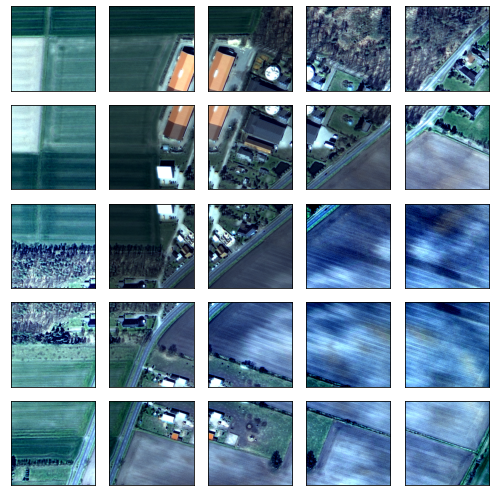

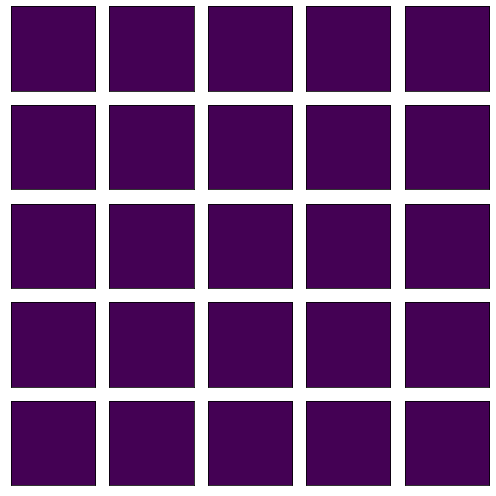

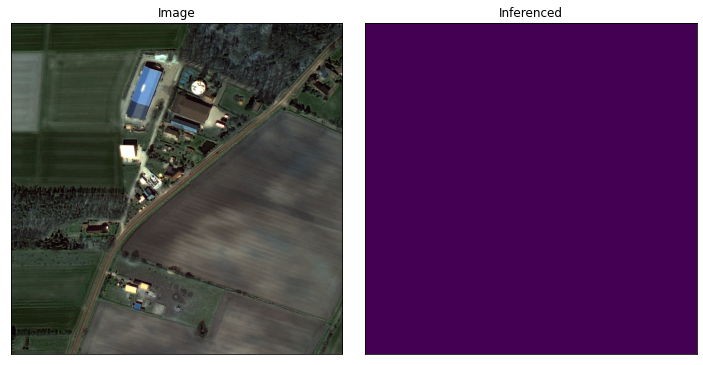

In [37]:
n = 5
ids = np.random.choice(np.arange(100), size=1)

STRIDE_SIZE = 192
INPUT_SIZE = 256
pts = get_slice_pos(25, STRIDE_SIZE, INPUT_SIZE)
with h5py.File(FILE_PATH, 'r') as f:
    for i in ids:
        img = f[VAL_IMG_PATH][i]
        inferenced = inference(img, pts)

        visualize(
            image=cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
            inferenced=inferenced
        )